In [1]:
### automatically refresh the buffer

%load_ext autoreload
%autoreload 2

### solve the auto-complete issue

%config Completer.use_jedi = False

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge, Circle
import geopandas as gpd
from shapely.geometry import Point

In [2]:
df_99tile = pd.read_csv('EP99_GSDR.csv')
df_ = df_99tile.drop(df_99tile.columns[0], axis=1)

### 99 Quantile EP Mean ---------------------------------------------------------

In [3]:
station_columns = df_.columns[2:]
df = df_.groupby('Year')[station_columns].mean()
df.reset_index(inplace=True)

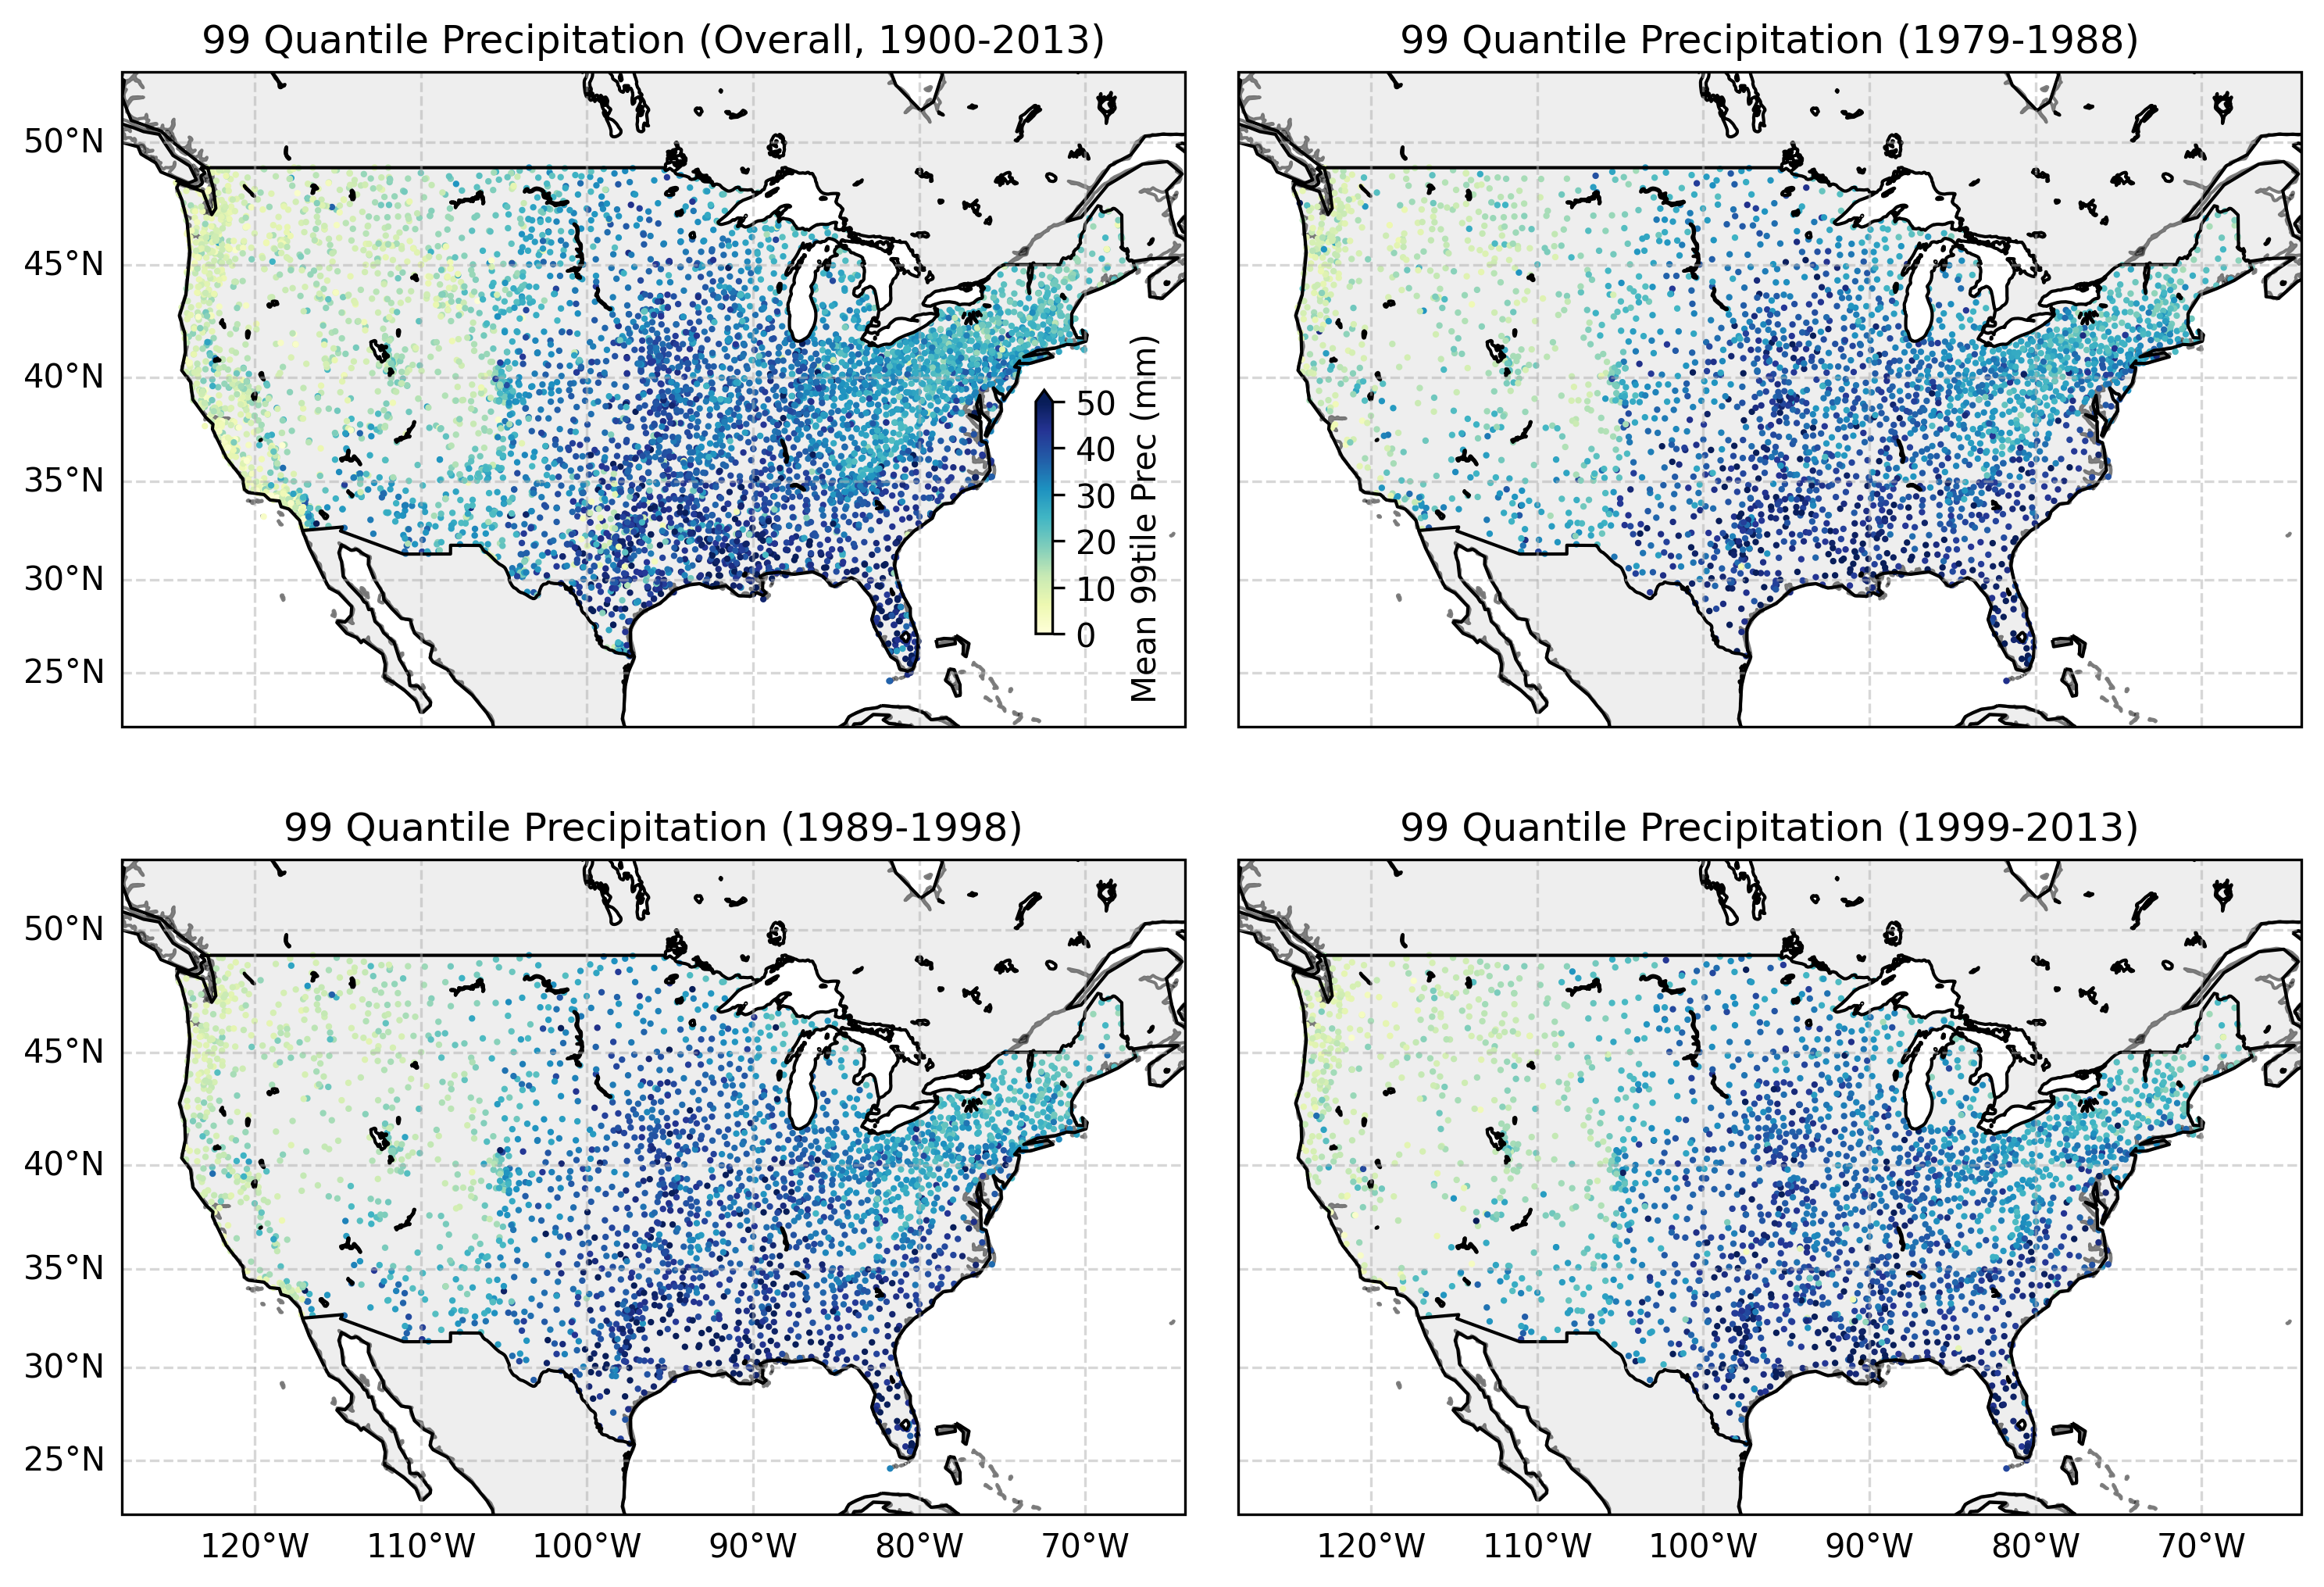

In [4]:
stations_info = df.columns[1:].tolist() 
time_periods = [(1900, 2013), (1979, 1988), (1989, 1998), (1999, 2013)]
titles = ['99 Quantile Precipitation (Overall, 1900-2013)', '99 Quantile Precipitation (1979-1988)', '99 Quantile Precipitation (1989-1998)', '99 Quantile Precipitation (1999-2013)']

fig, axes = plt.subplots(2, 2, figsize=(12,8), dpi=300, subplot_kw={'projection': ccrs.Mercator()})
extent = [-128, -64, 22, 48]

axes = axes.ravel()

for i, ((start_year, end_year), title) in enumerate(zip(time_periods, titles)):
    ax = axes[i]
    # for spine in ax.spines.values():
    #     spine.set_visible(False)
    mean_values = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)].mean()

    longitudes = [float(station.split(", ")[2]) for station in stations_info]
    latitudes = [float(station.split(", ")[3]) for station in stations_info]
    mean_vals = [mean_values[station] for station in stations_info]

    ax.set_extent(extent, crs=ccrs.Geodetic())
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='#dedede', alpha=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='w')
    ax.coastlines(resolution='110m')

    scatter = ax.scatter(longitudes, latitudes, c=mean_vals, cmap='YlGnBu', s=1, transform=ccrs.PlateCarree(),vmin=0.0, vmax=50)
    ax.set_title(title)
    
    gridlines = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

    # Simplified label control based on subplot index
    label_settings = [
        {'right_labels': False, 'top_labels': False, 'bottom_labels': False, 'left_labels': True},
        {'right_labels': False, 'top_labels': False, 'bottom_labels': False, 'left_labels': False},
        {'right_labels': False, 'top_labels': False, 'bottom_labels': True, 'left_labels': True},
        {'right_labels': False, 'top_labels': False, 'bottom_labels': True, 'left_labels': False}
    ]

    settings = label_settings[i]
    gridlines.right_labels = settings['right_labels']
    gridlines.top_labels = settings['top_labels']
    gridlines.bottom_labels = settings['bottom_labels']
    gridlines.left_labels = settings['left_labels']
    fig.subplots_adjust(wspace=0.05)
    if i == 1:
        cax1 = fig.add_axes([0.45, 0.58, 0.006, 0.13]) 
        cbar1 = plt.colorbar(scatter, cax=cax1, extend='max')
        cbar1.set_label('Mean 99tile Prec (mm)')
        scatter.set_clim(vmin=0.0, vmax=50)
        cbar1.set_ticks([0, 10, 20, 30, 40, 50])
    
plt.show()

### --------- 99 Quantile Most Frequent Hour / Hourly Maximum Precipitation -------------

In [5]:
clist1 =['#7cb3d4','#669dc7','#5185bb','#426cae','#3951a0','#303692',
        '#a60025','#bb1624','#d12927','#e14230','#ed5c3d','#f6774b',
        '#fa9359','#fdaf67','#fdc77c','#ffdc8f','#feeaa5','#fff8b7',
        '#f8fccd','#ebf7e4','#dcf1f7','#c4e6f0','#aadae8','#94c6de',]
red1 = LinearSegmentedColormap.from_list('chaos',clist1,N=24)

In [6]:
station_columns = df_99tile.columns[3:]  
hourly_count = df_99tile.groupby('Hour')[station_columns].count()
total_count = df_99tile[station_columns].count()
df = hourly_count / total_count
df.insert(0, 'Hour', list(range(24)) * (len(df) // 24))


In [7]:
df_ep_freq = pd.DataFrame(columns=['lat', 'lon', 'hour'])
station_cols = df.columns[1:]
rows = []

for col in station_cols:
    max_value = df[col].max()
    max_hour = df[df[col] == max_value]['Hour']
    if len(max_hour) == 1:
        if df[col].isna().sum() < 5:
            parts = col.split(', ')
            lat = float(parts[3])
            lon = float(parts[2])
            rows.append({'lat': lat, 'lon': lon, 'hour': max_hour.iloc[0]})
df_ep_freq = pd.DataFrame(rows)

In [8]:
df_data = df_99tile.iloc[:, 3:]
df_maxprec = df_data.max()
df_maxprec = pd.DataFrame([df_maxprec.values], columns=df_maxprec.index)

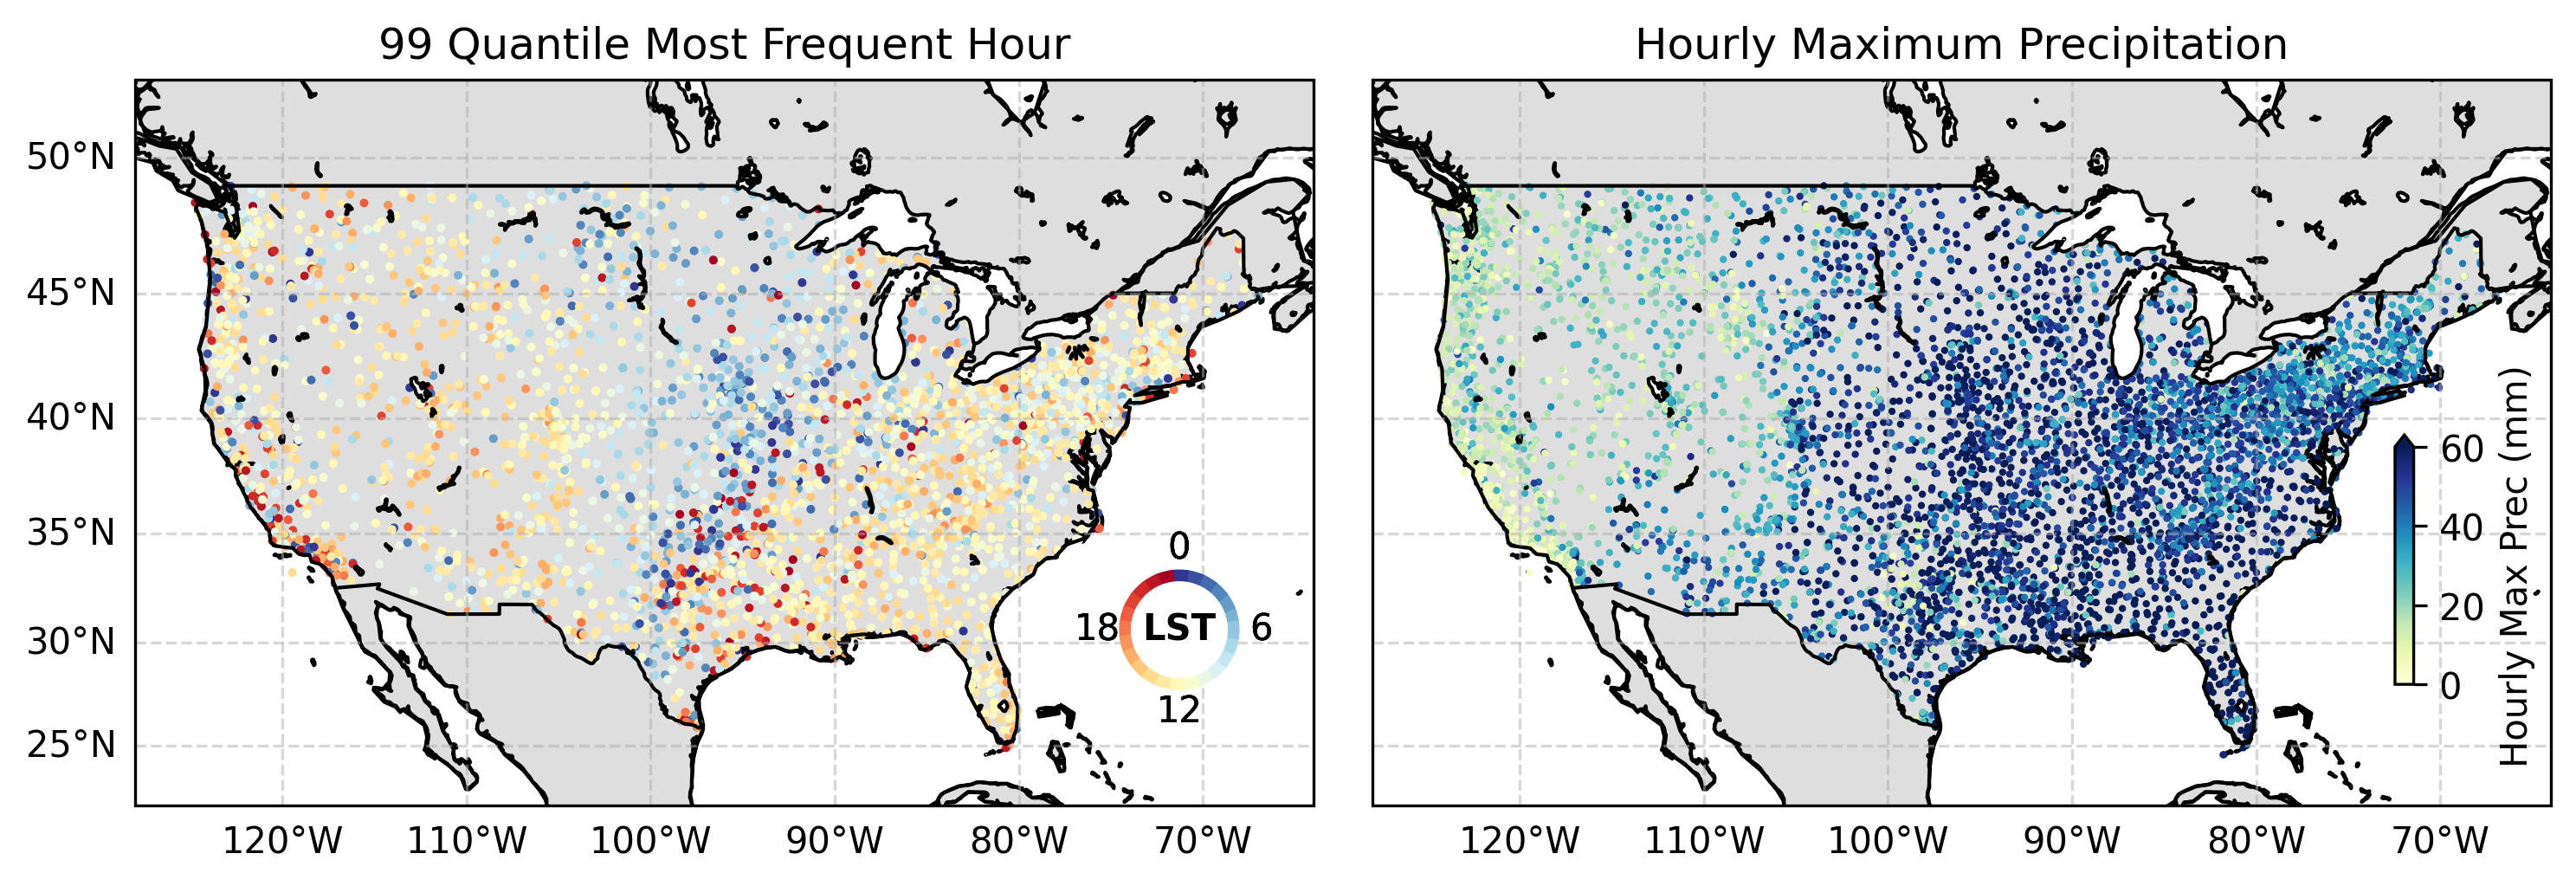

In [9]:
stations_info = df.columns[1:].tolist() 
time_periods = [(1900, 2013), (1979, 1988), (1989, 1998), (1999, 2013)]
titles = ['Circular Mean of Wet Hour (Overall, 1900-2013)', 'Circular Mean of Wet Hour (1979-1988)', 'Circular Mean of Wet Hour (1989-1998)', 'Circular Mean of Wet Hour (1999-2013)']

fig, axes = plt.subplots(1, 2, figsize=(12,6), dpi=300, subplot_kw={'projection': ccrs.Mercator()})
extent = [-128, -64, 22, 48]

for i in range(0,2):
    axes = axes.ravel()
    axes[i].set_extent(extent, crs=ccrs.Geodetic())
    axes[i].add_feature(cfeature.LAND, edgecolor='black', facecolor='#dedede')
    axes[i].add_feature(cfeature.BORDERS, linestyle='-')
    axes[i].add_feature(cfeature.LAKES, edgecolor='black', facecolor='w')
    axes[i].coastlines(resolution='110m')

scatter1 = axes[0].scatter(df_ep_freq.lon.values, df_ep_freq.lat.values, c=df_ep_freq.hour.values, cmap=red1, s=2, transform=ccrs.PlateCarree())
axes[0].set_title('99 Quantile Most Frequent Hour')
gridlines = axes[0].gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gridlines.right_labels = False
gridlines.top_labels = False

scatter2 = axes[1].scatter(longitudes, latitudes, c=df_maxprec.values.reshape(6314,), cmap='YlGnBu', s=1, transform=ccrs.PlateCarree())
axes[1].set_title('Hourly Maximum Precipitation')
gridlines = axes[1].gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gridlines.right_labels = False
gridlines.top_labels = False
gridlines.left_labels = False



fig.subplots_adjust(wspace=0.05)

################################ insert a ax!!
inset_ax = fig.add_axes([0.425, 0.33, 0.07, 0.09], zorder=2, frameon=False)
rotation_angle = -7.5
n_segments = 24
theta = np.linspace(0, 2 * np.pi, n_segments + 1)

for i in range(n_segments):
    wedge = Wedge((0, 0), 1, np.degrees(theta[i]) - rotation_angle, np.degrees(theta[i+1]) - rotation_angle,
                  color=red1(i / (n_segments - 1)), edgecolor='none')
    inset_ax.add_patch(wedge)

inset_ax.add_patch(Circle((0, 0), 0.8, color='white', zorder=1))

inset_ax.set_xlim(-1.2, 1.2)
inset_ax.set_ylim(-1.2, 1.2)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_aspect('equal')
inset_ax.text(0, 0, 'LST', ha='center', va='center', weight='bold')
for spine in inset_ax.spines.values():
    spine.set_visible(False)
    for i in range(n_segments):
        if i % 6 ==0:
            angle = theta[i] - np.pi / 2 - np.radians(-90)
            x, y = 1.4 * np.sin(angle), 1.4 * np.cos(angle)
            inset_ax.text(x, y, str(i), ha='center', va='center',)
            
cax1 = fig.add_axes([0.85, 0.34, 0.006, 0.16]) 
cbar1 = plt.colorbar(scatter2, cax=cax1, extend='max')
cbar1.set_label('Hourly Max Prec (mm)')
scatter2.set_clim(vmin=0.0, vmax=60)
cbar1.set_ticks([0, 20, 40, 60])

plt.show()

### ----------Diurnal variation of precipitation-----------

In [10]:
df_hour_count = pd.read_csv('prec99_hour_count_GSDR.csv')
df_hour_count = df_hour_count.iloc[:,1:]

In [11]:
US = gpd.read_file('../../tl_2019_us_state/tl_2019_us_state.shp')

regions_dict = {
    'NE': ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT', 'WV'],
    'Midwest': ['IA', 'MI', 'MN', 'WI', 'IL', 'IN', 'MO', 'OH'],
    'SE': ['AL', 'FL', 'GA', 'NC', 'SC', 'VA', 'TN', 'KY', 'AR', 'LA', 'MS'],
    'NGP': ['MT', 'NE', 'ND', 'SD', 'WY'],
    'SGP': ['KS', 'OK', 'TX'],
    'SW': ['AZ', 'CO', 'NM', 'UT', 'CA', 'NV'],
    'NW': ['ID', 'OR', 'WA']
}
regions = {name: US[US['STUSPS'].isin(states)] for name, states in regions_dict.items()}
columns = df_hour_count.columns[2:]


stations_coords = {
    col: tuple(map(float, col.split(',')[2:4])) 
    for col in df_hour_count.columns[1:] 
    if len(col.split(',')) >= 4
}

df_region = {region: pd.DataFrame(df_hour_count[['year', 'hour']]) for region in regions_dict.keys()}

for station, coords in stations_coords.items():
    point = Point(coords)
    region_found = False
    for region, gdf in regions.items():
        if gdf.contains(point).any():
            df_region[region][station] = df_hour_count[station]
            region_found = True
            break
    if not region_found:
        print(f"Station {station} not found in any region.")

Station US_326535, UTC-6, -102.26667, 49.0 not found in any region.
Station US_177435, UTC-5, -69.75, 46.95 not found in any region.
Station US_189290, UTC-5, -77.050278, 38.901111 not found in any region.


In [12]:
regions = ['NE', 'Midwest', 'SE', 'NGP', 'SGP', 'SW', 'NW']

dic_results = {'1900-1988': {}, '1989-2013': {}}

for region in regions:
    
    df = df_region[region]
    df['year'] = df['year'].astype(int)
    data_1900_1988 = df[df['year'].between(1900, 1988)]
    data_1989_2013 = df[df['year'].between(1989, 2013)]
    
    total_1900_1988 = data_1900_1988.drop(columns=['year']).groupby('hour').sum(numeric_only=True).sum(axis=1).reset_index()
    total_1900_1988.columns = ['hour', 'total']

    total_1989_2013 = data_1989_2013.drop(columns=['year']).groupby('hour').sum(numeric_only=True).sum(axis=1).reset_index()
    total_1989_2013.columns = ['hour', 'total']

    dic_results['1900-1988'][region] = total_1900_1988
    dic_results['1989-2013'][region] = total_1989_2013

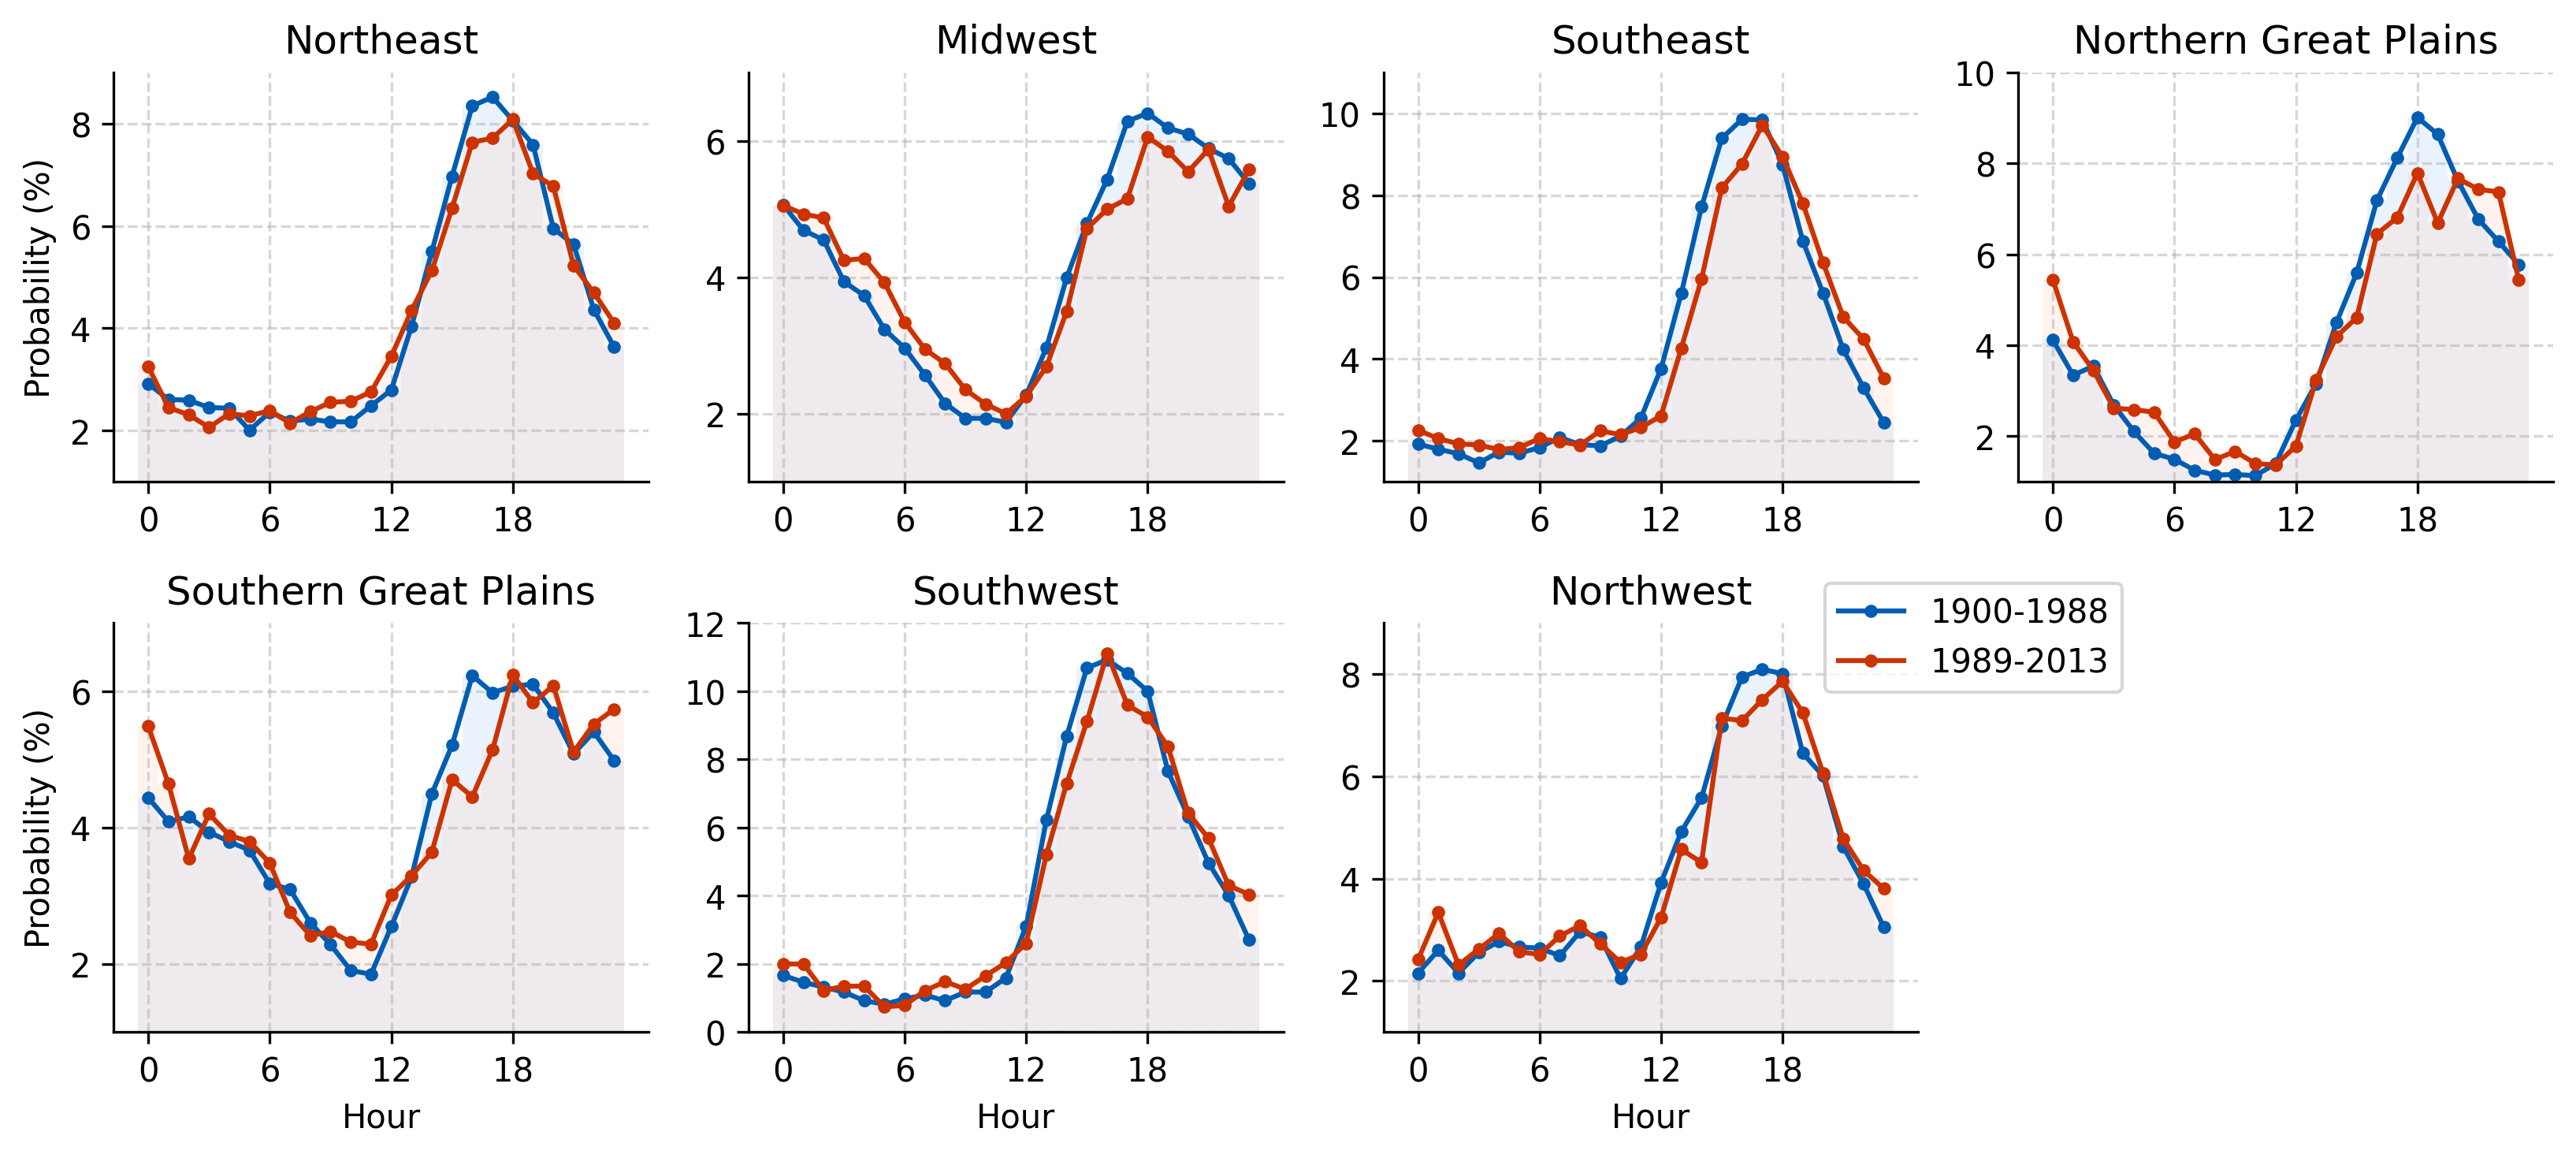

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(11, 5), dpi=300)
axes = axes.flatten()
ylim_settings = [(0.01, 0.09), (0.01, 0.07), (0.01, 0.11), (0.01, 0.10), (0.01, 0.07), (0.00, 0.12), (0.01, 0.09)]
regions_name = ['Northeast', 'Midwest', 'Southeast', 'Northern Great Plains', 'Southern Great Plains', 'Southwest', 'Northwest']
line_handles = []
line_labels = []

# To track which lines have been added
added_regions = set()

for i, region in enumerate(regions):
    ax = axes[i]

    total_1900_1988 = dic_results['1900-1988'][region]
    total_1989_2013 = dic_results['1989-2013'][region]
    
    sum_1900_1988 = total_1900_1988.drop(columns=['year'], errors='ignore').sum(axis=1)
    sum_1989_2013 = total_1989_2013.drop(columns=['year'], errors='ignore').sum(axis=1)

    prob_1900_1988 = sum_1900_1988 / sum_1900_1988.sum()
    prob_1989_2013 = sum_1989_2013 / sum_1989_2013.sum()
    
    plot_data_1900_1988 = pd.DataFrame({'hour': total_1900_1988['hour'], 'prob': prob_1900_1988})
    plot_data_1989_2013 = pd.DataFrame({'hour': total_1989_2013['hour'], 'prob': prob_1989_2013})

    ax.bar(plot_data_1900_1988['hour'], plot_data_1900_1988['prob'], width=1, label='1900-1988', color='#99c7f2', alpha=0.2)
    ax.bar(plot_data_1989_2013['hour'], plot_data_1989_2013['prob'], width=1, label='1989-2013', color='#ffc6b3', alpha=0.2)

    if region not in added_regions:
        line_1900_1988, = ax.plot(plot_data_1900_1988['hour'], plot_data_1900_1988['prob'], color='#015db2', linestyle='-', marker='o', ms=3, label='1900-1988 (Line)')
        line_1989_2013, = ax.plot(plot_data_1989_2013['hour'], plot_data_1989_2013['prob'], color='#cc3300', linestyle='-', marker='o', ms=3, label='1989-2013 (Line)')
        

        
        added_regions.add(region)
    else:
        # If the region is already added, plot bars only
        ax.bar(plot_data_1900_1988['hour'], plot_data_1900_1988['prob'], width=1, color='#99c7f2', alpha=0.2)
        ax.bar(plot_data_1989_2013['hour'], plot_data_1989_2013['prob'], width=1, color='#ffc6b3', alpha=0.2)

    ax.set_title(f'{regions_name[i]}')

    ax.set_yticks(ax.get_yticks()) 
    ax.set_yticklabels([f'{int(y*100)}' for y in ax.get_yticks()])
    ax.set_xticks([0, 6, 12, 18])
    ax.grid(True, ls='--', alpha=0.5)
    if i < len(ylim_settings):
        ax.set_ylim(ylim_settings[i])

    if i in [4,5,6]:
        ax.set_xlabel('Hour')
    if i in [0,4]:
        ax.set_ylabel('Probability (%)')


    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

if len(regions) < len(axes):
    for j in range(len(regions), len(axes)):
        fig.delaxes(axes[j])
line_handles.extend([line_1900_1988, line_1989_2013])
line_labels.extend(['1900-1988', '1989-2013'])
fig.legend(line_handles, line_labels, loc='center left', bbox_to_anchor=(0.7, 0.45), ncol=1)
        
plt.tight_layout()
plt.show()

### ----- Circular Mean of 99 tile -----------

In [36]:
clist1 =['#7cb3d4','#669dc7','#5185bb','#426cae','#3951a0','#303692',
        '#a60025','#bb1624','#d12927','#e14230','#ed5c3d','#f6774b',
        '#fa9359','#fdaf67','#fdc77c','#ffdc8f','#feeaa5','#fff8b7',
        '#f8fccd','#ebf7e4','#dcf1f7','#c4e6f0','#aadae8','#94c6de',]
red1 = LinearSegmentedColormap.from_list('chaos',clist1,N=24)

In [37]:
df = pd.read_csv('/N/project/Zli_lab/gongg/GSDR_code/circular_mean_99tile_GSDR.csv')
years = list(range(1900, 2014))  
df.insert(0, 'year', years)  

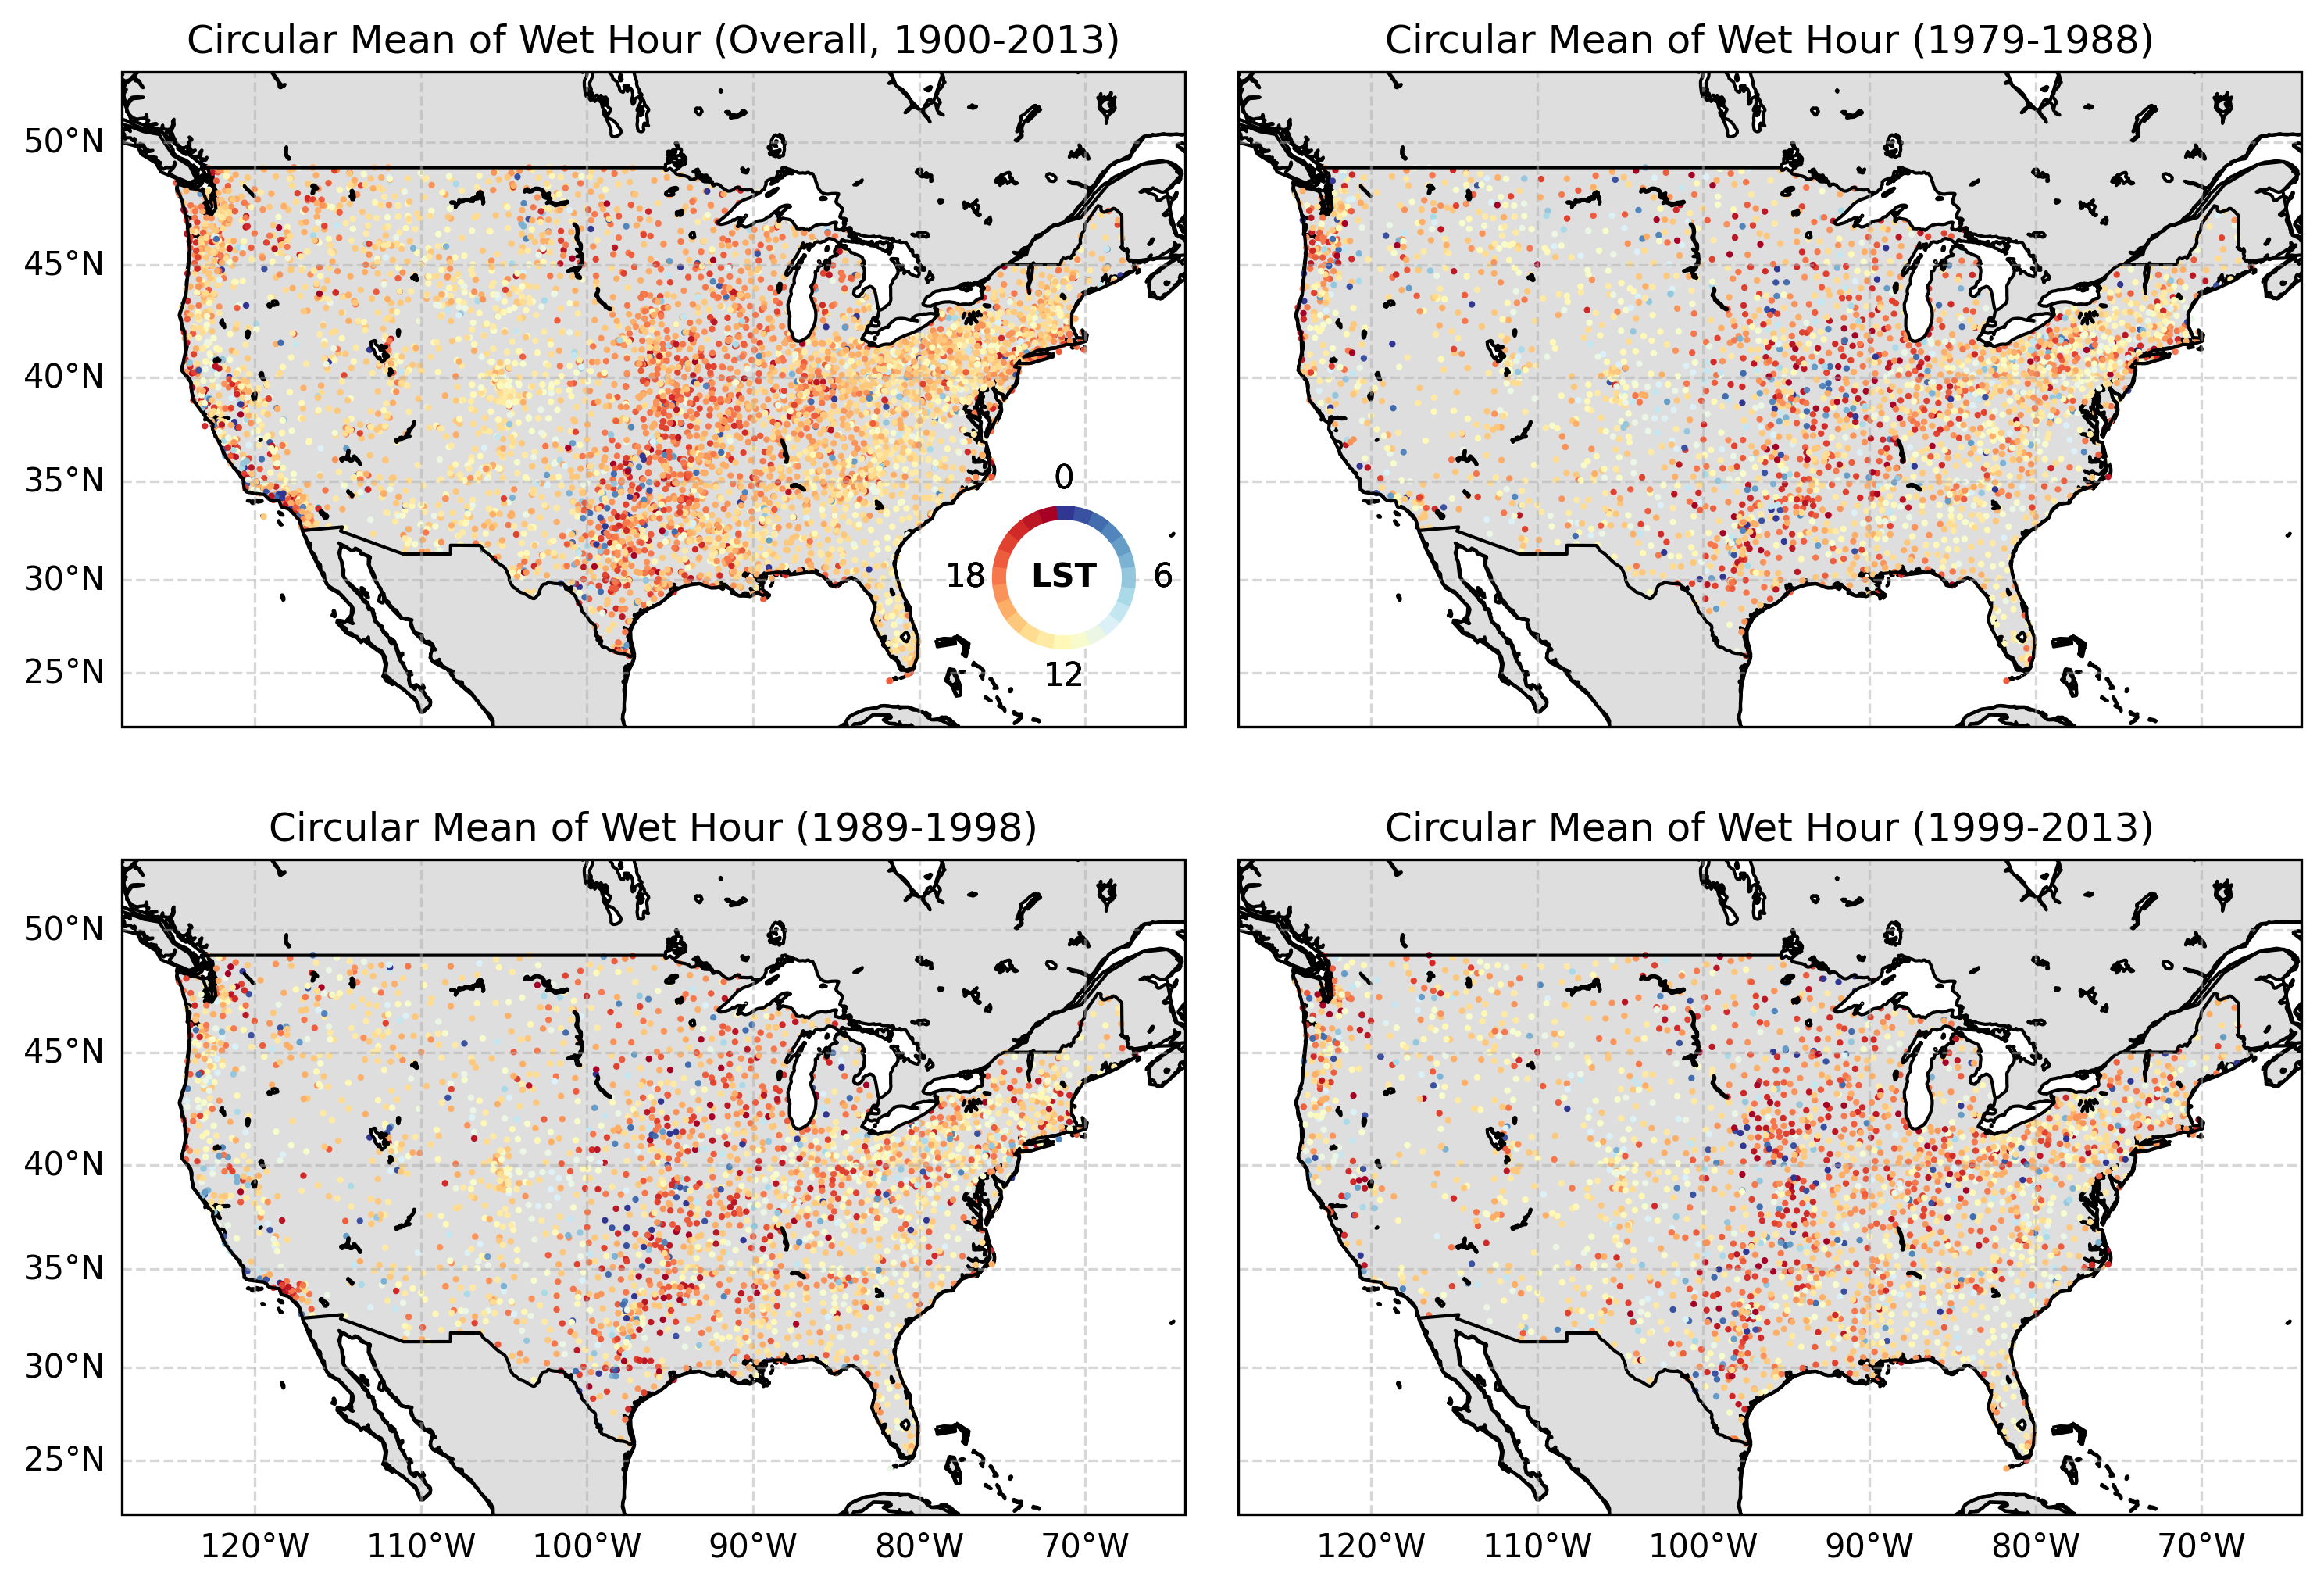

In [39]:
stations_info = df.columns[1:].tolist() 
time_periods = [(1900, 2013), (1979, 1988), (1989, 1998), (1999, 2013)]
titles = ['Circular Mean of Wet Hour (Overall, 1900-2013)', 'Circular Mean of Wet Hour (1979-1988)', 'Circular Mean of Wet Hour (1989-1998)', 'Circular Mean of Wet Hour (1999-2013)']

fig, axes = plt.subplots(2, 2, figsize=(12,8), dpi=300, subplot_kw={'projection': ccrs.Mercator()})
extent = [-128, -64, 22, 48]
axes = axes.flatten()
# axes = axes.ravel()

for i, ((start_year, end_year), title) in enumerate(zip(time_periods, titles)):
    ax = axes[i]
    # for spine in ax.spines.values():
    #     spine.set_visible(False)
    mean_values = df[(df['year'] >= start_year) & (df['year'] <= end_year)].mean()

    longitudes = [float(station.split(", ")[2]) for station in stations_info]
    latitudes = [float(station.split(", ")[3]) for station in stations_info]
    mean_vals = [mean_values[station] for station in stations_info]

    ax.set_extent(extent, crs=ccrs.Geodetic())
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='#dedede')
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='w')
    ax.coastlines(resolution='110m')

    scatter = ax.scatter(longitudes, latitudes, c=mean_vals, cmap=red1, s=1, transform=ccrs.PlateCarree()) #
    ax.set_title(title)
    
    gridlines = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

    # Simplified label control based on subplot index
    label_settings = [
        {'right_labels': False, 'top_labels': False, 'bottom_labels': False, 'left_labels': True},
        {'right_labels': False, 'top_labels': False, 'bottom_labels': False, 'left_labels': False},
        {'right_labels': False, 'top_labels': False, 'bottom_labels': True, 'left_labels': True},
        {'right_labels': False, 'top_labels': False, 'bottom_labels': True, 'left_labels': False}
    ]

    settings = label_settings[i]
    gridlines.right_labels = settings['right_labels']
    gridlines.top_labels = settings['top_labels']
    gridlines.bottom_labels = settings['bottom_labels']
    gridlines.left_labels = settings['left_labels']

fig.subplots_adjust(wspace=0.05)

################################ insert a ax!!
inset_ax = fig.add_axes([0.425, 0.565, 0.07, 0.09], zorder=2, frameon=False)
rotation_angle = -7.5
n_segments = 24
theta = np.linspace(0, 2 * np.pi, n_segments + 1)

for i in range(n_segments):
    wedge = Wedge((0, 0), 1, np.degrees(theta[i]) - rotation_angle, np.degrees(theta[i+1]) - rotation_angle,
                  color=red1(i / (n_segments - 1)), edgecolor='none')
    inset_ax.add_patch(wedge)

inset_ax.add_patch(Circle((0, 0), 0.8, color='white', zorder=1))

inset_ax.set_xlim(-1.2, 1.2)
inset_ax.set_ylim(-1.2, 1.2)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_aspect('equal')
inset_ax.text(0, 0, 'LST', ha='center', va='center', weight='bold')
for spine in inset_ax.spines.values():
    spine.set_visible(False)
    for i in range(n_segments):
        if i % 6 ==0:
            angle = theta[i] - np.pi / 2 - np.radians(-90)
            x, y = 1.4 * np.sin(angle), 1.4 * np.cos(angle)
            inset_ax.text(x, y, str(i), ha='center', va='center',)

plt.show()


### -----------99 quantile precipitation threshold------------

In [41]:
df = pd.read_csv('/N/project/Zli_lab/gongg/GSDR_code/quantiles_99_threshold_GSDR.csv')

In [42]:
thr_99 = df.values.reshape(6314,)

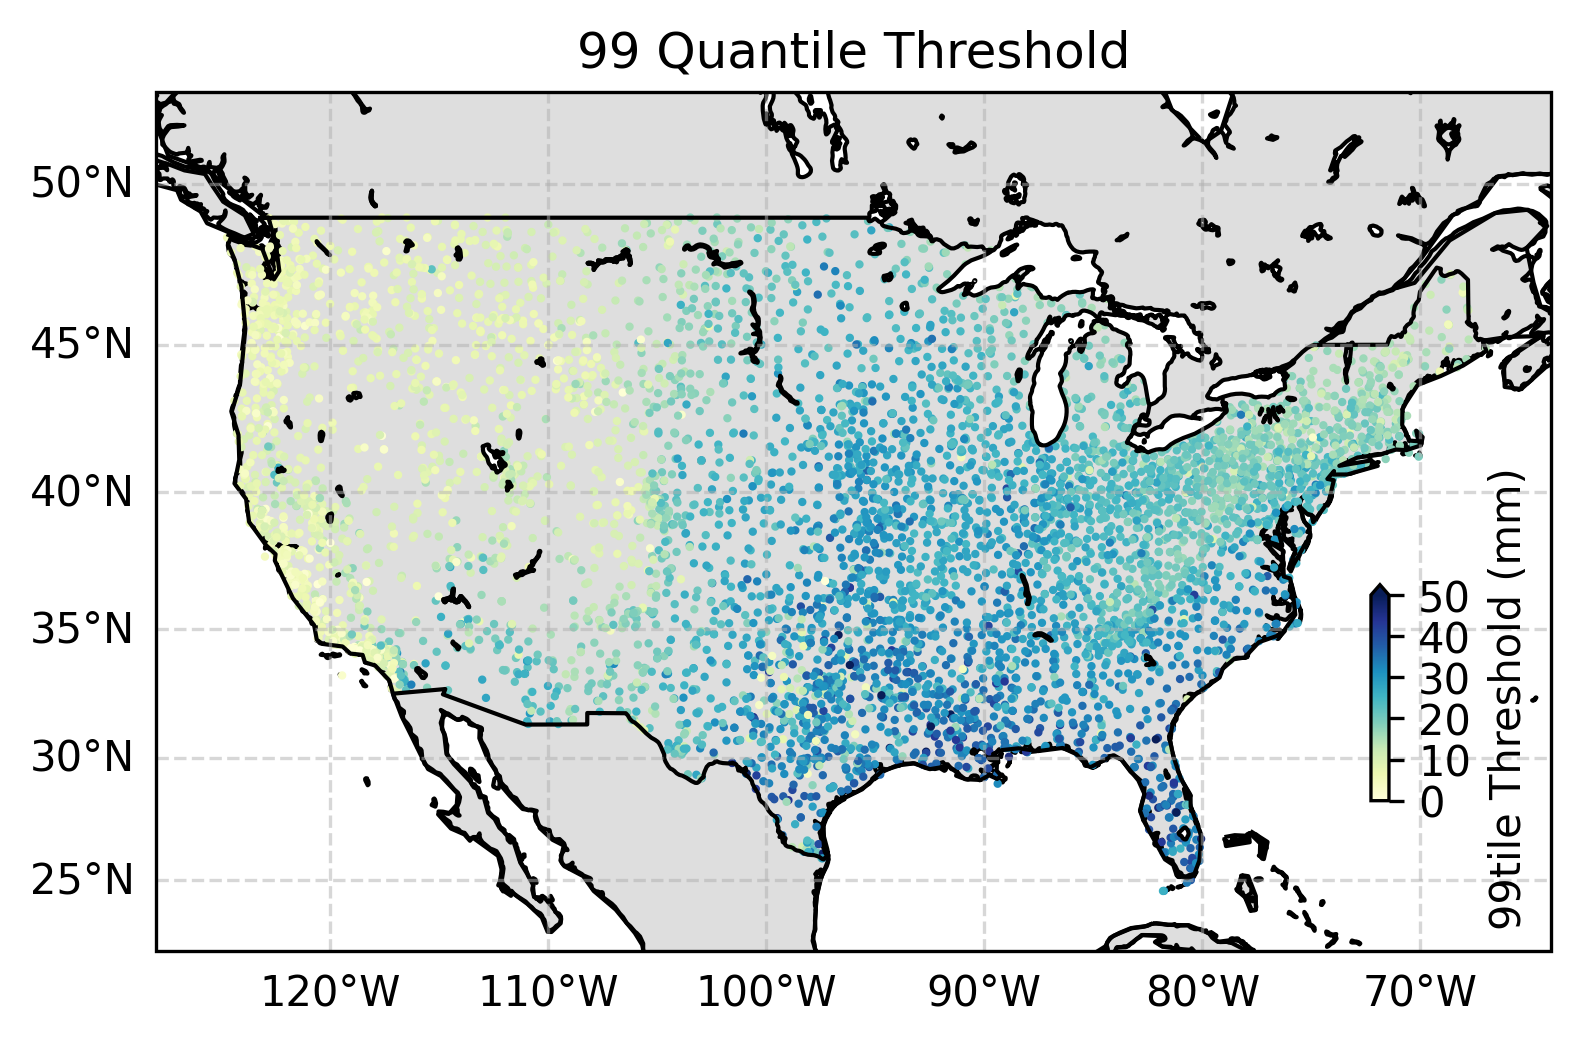

In [62]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=300, subplot_kw={'projection': ccrs.Mercator()})
extent = [-128, -64, 22, 48]

ax.set_extent(extent, crs=ccrs.Geodetic())
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='#dedede')
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='w')
ax.coastlines(resolution='110m')

scatter = ax.scatter(longitudes, latitudes, c=thr_99, vmax=50,s=1,cmap='YlGnBu', transform=ccrs.PlateCarree())
ax.set_title('99 Quantile Threshold')

gridlines = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gridlines.right_labels = False
gridlines.top_labels = False

cax1 = fig.add_axes([0.8, 0.34, 0.01, 0.12]) 
cbar1 = plt.colorbar(scatter, cax=cax1, extend='max')
cbar1.set_label('99tile Threshold (mm)')
scatter2.set_clim(vmin=0.0, vmax=50)
cbar1.set_ticks([0, 10, 20, 30, 40, 50])
plt.show()
